In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

In [2]:
output_file = 'results/TimeSelection/results_fixed'

total_metrics = pd.read_csv(f'{output_file}.csv')
total_metrics = total_metrics[(total_metrics.selection_name != 'SelectionLayer') & (total_metrics.dataset_params_seq_len<=24)].reset_index(drop=True)
total_metrics = total_metrics.drop(total_metrics[(total_metrics.dataset=='Electricity') & (total_metrics.dataset_params_shift==4)].index).reset_index(drop=True)

In [3]:
best_metrics = total_metrics.iloc[total_metrics.groupby(['dataset', 'selection_name', 'model_name']).mean_squared_error.idxmin()].reset_index(drop=True)
best_metrics["n_features"] = best_metrics.selected_features.apply(eval).apply(len)
best_metrics.pivot(values=['n_features'], index = ['dataset'], columns=[ 'selection_name'])#.to_latex()

n_features                                       \
selection_name Correlation Linear MutualInformation NoSelection   
dataset                                                           
ETTh1                   32      8                16         168   
ETTh2                   40      3                33          84   
Electricity           2568   2553              2568        2568   
ExchangeRate            24     43                24          24   
TorneoCO                35     14                39         168   
TorneoNO2               83      4                51          84   
TorneoO3                19      5                32          84   
TorneoPM10             126      8                67          84   
Traffic               4745   4655              4812        5172   

                                   
selection_name TimeSelectionLayer  
dataset                            
ETTh1                           1  
ETTh2                           6  
Electricity                   369  
ExchangeRate                   12  
TorneoCO                        4  
TorneoNO2                       4  
TorneoO3                        2  
TorneoPM10                     19  
Traffic                      1010

In [8]:
best_metrics = total_metrics.iloc[total_metrics.groupby(['dataset', 'selection_name', 'model_name']).mean_squared_error.idxmin()].reset_index(drop=True)
best_metrics['n_features'] = best_metrics.selected_features.apply(eval).apply(len)
best_metrics.pivot(values=['n_features'], index = ['dataset'], columns=['selection_name' ])#.to_latex()

n_features                                       \
selection_name Correlation Linear MutualInformation NoSelection   
dataset                                                           
ETTh1                   32      8                16         168   
ETTh2                   40      3                33          84   
Electricity           2568   2553              2568        2568   
ExchangeRate            24     43                24          24   
TorneoCO                35     14                39         168   
TorneoNO2               83      4                51          84   
TorneoO3                19      5                32          84   
TorneoPM10             126      8                67          84   
Traffic               4745   4655              4812        5172   

                                   
selection_name TimeSelectionLayer  
dataset                            
ETTh1                           1  
ETTh2                           6  
Electricity                   369  
ExchangeRate                   12  
TorneoCO                        4  
TorneoNO2                       4  
TorneoO3                        2  
TorneoPM10                     19  
Traffic                      1010

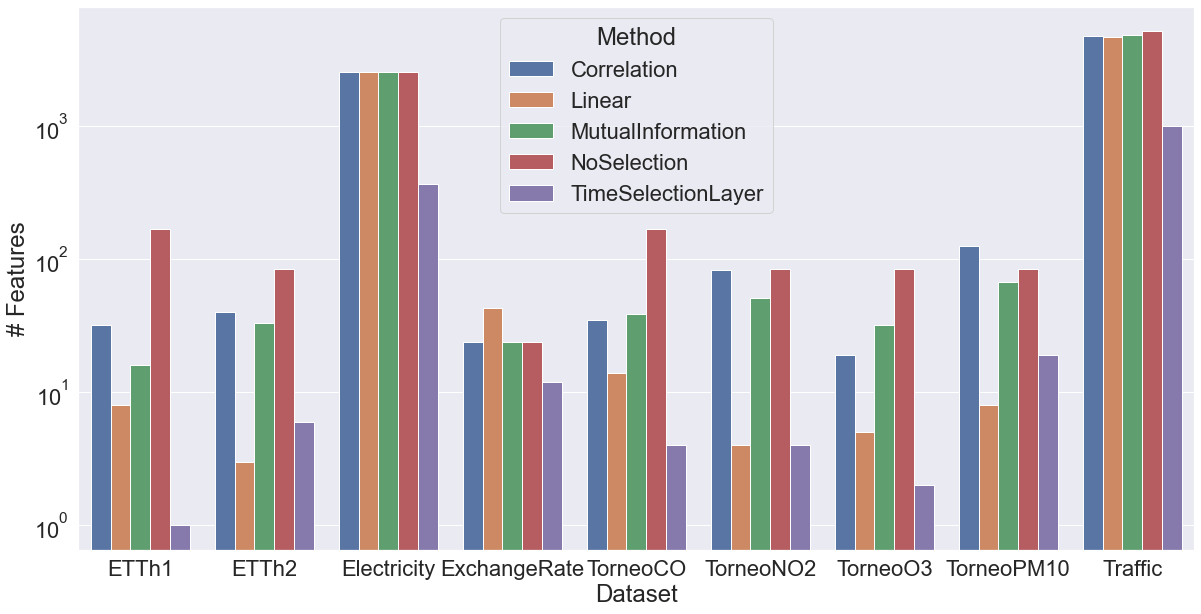

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
sns.barplot(data=best_metrics.rename(columns={"dataset": "Dataset", "n_features": "# Features", "selection_name": "Method"}), x="Dataset", y="# Features", hue="Method").set_yscale("log")

